In [1]:
import re
import pandas as pd
import requests
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import *
import matplotlib.pyplot as plt
from io import StringIO
import matplotlib.pyplot as plt

import csv
csv.field_size_limit(131072000)
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle 

### Hent data

In [10]:

# URL of the CSV file
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'

# Fetching the content from the URL
response = requests.get(url)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    # Reading CSV data using pandas
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)

    # Displaying the first few rows of the DataFrame
    #print(df.head())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


# Part 1

# Task 1

In [8]:
def clean_text(text):
    text = text.lower()
    # remove multiple white spaces/tabs or newlines
    mul_uni_whitespaces = re.compile(r'(\s)\s+')
    text = mul_uni_whitespaces.sub(r'\1',text)
    # extract dates with form
    # YY-MM-DD HH-MM:SS
    date = re.compile(r"""
        # YY
        ([0-1][0-9]{3}|20[0-1][0-9]|202[0-4])
        -
        # MM 01-12, DD: 01-31
        (1[0-2]|0[1-9])
        -
        ([1-3]0|[0-2][1-9]|31)
        # whitespace
        \ {1}
        # HH-MM:SS format
        ([0-1][0-9]|2[0-4]):([0-5][0-9]|60):([0-5][0-9].\d*)
        """, re.X)
    text = date.sub(r'<DATE>',text)
    # extract date with alphabetic name, year
    # example: Jan DD, YYYY
    date_2 = re.compile(r"""
        ([A-Z]|[a-z])([a-z]+\ )([1-3]0|[0-2][1-9]|31)
        ,\ {1}
        # YY 0000-2023
        ([0-1][0-9]{3}|20[0-1][0-9]|202[0-4])
        """, re.X)
    text = date_2.sub(r'<DATE>',text)
    
    number = re.compile(r"""
        (\d+[,\.]\d+)|(\d+)  
        (?![\w])             # next character has to be a non-word letter
        """, re.X)
    text = number.sub(r'<NUM>',text)
    
    email = re.compile(r"""
        [\w-]+@[\.\w-]+              # if we have @ we assume it's an email 
        """, re.X)
    text = email.sub(r'<EMAIL>',text)
    
    # website with prefix http and/or www.
    website_http = re.compile(r"""
        (https?://www\.|              # http(s)://www. or www.
        https?://|www\.)              # or http(s)://
        ([^ \t\n\r\f\v,]+)             # capture rest of website    
        """, re.X)
    text = website_http.sub(r'<URL>',text)
    # website with prefix http and/or www.
    website = re.compile(r"""        # no https or www
        [\w-]+\.[\.\w-]+             # assume website if we have a dot .
        (/[^ \t\n\r\f\v,]*)?         # /<address> optional     
        """, re.X)
    text = website.sub(r'<URL>',text)
    return text


In [11]:
concat_content = " ".join(df['content'].tolist())
cleaned_content = clean_text(concat_content)
tokens = nltk.word_tokenize(cleaned_content)
tokens = [token for token in tokens if token.isalpha()]

# stop word removal
vocab_pre_stop = len(np.unique(tokens))
stop_words = stopwords.words('english')
tokens_no_stop = [token for token in tokens if not token in stop_words]
vocab_post_stop = len(np.unique(tokens_no_stop))

# stemming
stemmer = PorterStemmer()
tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]
vocab_post_stem = len(np.unique(tokens_stem))

print(f"Vocabulary size before removing stop words: {vocab_pre_stop}")
print(f"Vocabulary size before after stop words: {vocab_post_stop}")
print(f"Total Reduction rate is: {(vocab_pre_stop-vocab_post_stop)/vocab_pre_stop}")
print(f"\nVocabulary size after stemming: {vocab_post_stem}")
print(f"Total Reduction rate after stemming: {(vocab_pre_stop-vocab_post_stem)/vocab_pre_stop}")

Vocabulary size before removing stop words: 14961
Vocabulary size before after stop words: 14815
Total Reduction rate is: 0.00975870596885235

Vocabulary size after stemming: 9674
Total Reduction rate after stemming: 0.35338546888576966


# Task 2

In [2]:
# compute vocab frequency before stop words / stemming

chunksize = 50000
word_dict = {}

for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        clean_data = clean_text(content)
        tokens = nltk.word_tokenize(clean_data)
        tokens = [token for token in tokens if token.isalpha()]
        for k in range(len(tokens)):
            word = tokens[k]
            if word not in word_dict:
                word_dict[word] = 1
            else:
                count = word_dict[word]
                word_dict.update({word:count+1})


In [4]:
# vocab freq after stop word / stemming

chunksize = 100000
import matplotlib.pyplot as plt

word_dict_post = {}

for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        clean_data = clean_text(content)
        tokens = nltk.word_tokenize(clean_data)
        tokens = [token for token in tokens if token.isalpha()]

        stop_words = stopwords.words('english')
        tokens_no_stop = [token for token in tokens if not token in stop_words]

        # stemming
        stemmer = PorterStemmer()
        tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]

        for k in range(len(tokens_stem)):
            word = tokens_stem[k]
            if word not in word_dict_post:
                word_dict_post[word] = 1
            else:
                count = word_dict_post[word]
                word_dict_post.update({word:count+1})

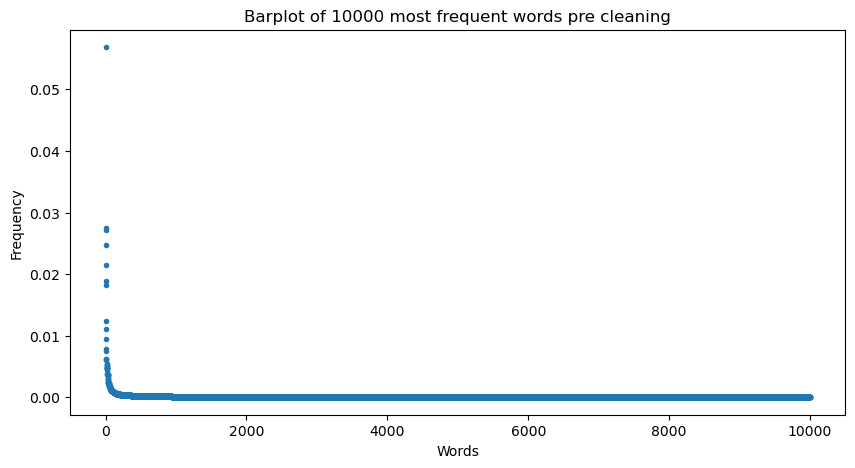

In [5]:
# Analysis of word frequency
freq_100 = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[0:100]
freq_10000 = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[0:10000]
freq_10000_words = [word[0] for word in freq_10000]
word_sum = sum(word_dict.values())
frequency_10000 = [word[1]/word_sum for word in freq_10000]

plt.figure(figsize=(10,5))
## Create bars
plt.plot(frequency_10000,'.')
plt.ylabel("Frequency")
plt.title("Barplot of 10000 most frequent words pre cleaning")
plt.xlabel("Words")
plt.show()

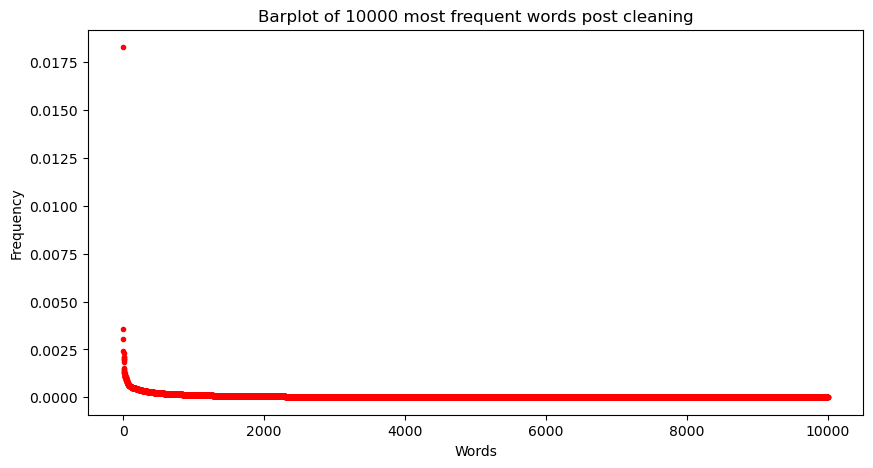

In [6]:
# Analysis of word frequency
freq_100_post = sorted(word_dict_post.items(), key=lambda x: x[1], reverse=True)[0:100]
freq_10000_post = sorted(word_dict_post.items(), key=lambda x: x[1], reverse=True)[0:10000]
freq_10000_words_post = [word[0] for word in freq_10000_post]
word_sum_post = sum(word_dict_post.values())
frequency_10000_post = [word[1]/word_sum for word in freq_10000_post]

plt.figure(figsize=(10,5))
## Create bars
plt.plot(frequency_10000_post,'.',color='red')
plt.ylabel("Frequency")
plt.title("Barplot of 10000 most frequent words post cleaning")
plt.xlabel("Words")
plt.show()

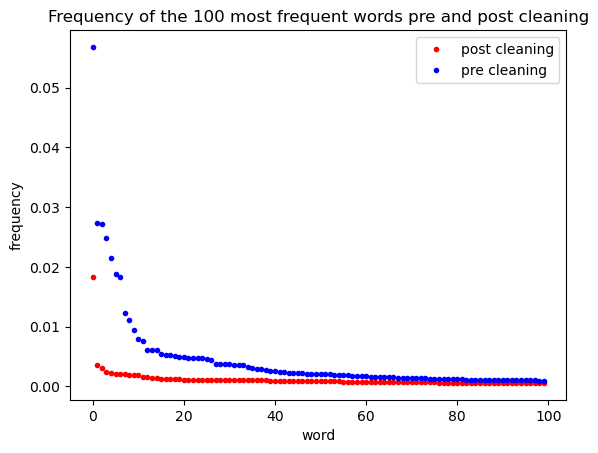

In [7]:
plt.plot(frequency_10000_post[0:100],'.',color='red',label='post cleaning')
plt.plot(frequency_10000[0:100],'.',color='blue',label='pre cleaning')
plt.title('Frequency of the 100 most frequent words pre and post cleaning')
plt.xlabel('word')
plt.ylabel('frequency')
plt.legend()
plt.show()

# Task 3

In [19]:
def tokenize_content(content, stop_words, stemmer):  
    cleaned_content = clean_text(content)
    tokens = nltk.word_tokenize(cleaned_content)
    # tokenize all alphabetic words
    tokens = [token for token in tokens if token.isalpha()]
    
    # remove stop words by filtering
    tokens_no_stop = [token for token in tokens if not token in stop_words]
    # stem words using Porterstemmer
    tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]

    return tokens_stem

content_token = {'tokenized': []}
token_df = pd.DataFrame(content_token)

chunksize = 50000
counter = 0
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):
    counter += 1
    if counter == 6:
        token_df.to_csv('tokenized_content_1-5.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    if counter == 11:
        token_df.to_csv('tokenized_content_6-10.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    if counter == 16:
        token_df.to_csv('tokenized_content_11-15.csv', index=False)
        content_token = {'tokenized': []}
        token_df = pd.DataFrame(content_token)
    chunk = chunk.dropna(subset = ['type'])
    chunk = chunk.dropna(subset = ['content'])
    for i in range(len(chunk['content'])):
        content = chunk['content'].iloc[i]
        content_token = tokenize_content(content, stop_words, stemmer)
        token_df.loc[len(token_df.index)] = [content_token]
token_df.to_csv('tokenized_content_16-end.csv', index=False)

df_part_1 = pd.read_csv('tokenized_content_1-5.csv')
df_part_2 = pd.read_csv('tokenized_content_6-10.csv')
df_part_3 = pd.read_csv('tokenized_content_11-15.csv')
df_part_4 = pd.read_csv('tokenized_content_16-end.csv')
combined_df = pd.concat(df_part_1,df_part_2,df_part_3, df_part_4,ignore_index=True)
combined_df.to_csv('rows_preprocessed.csv', index=False)

"\ncontent_token = {'tokenized': []}\ntoken_df = pd.DataFrame(content_token)\n\nchunksize = 50000\ncounter = 0\nstop_words = stopwords.words('english')\nstemmer = PorterStemmer()\nfor chunk in pd.read_csv('995,000_rows.csv', chunksize=chunksize):\n    counter += 1\n    print(counter)\n    if counter == 6:\n        token_df.to_csv('tokenized_content_1-5.csv', index=False)\n        content_token = {'tokenized': []}\n        token_df = pd.DataFrame(content_token)\n    if counter == 11:\n        token_df.to_csv('tokenized_content_6-10.csv', index=False)\n        content_token = {'tokenized': []}\n        token_df = pd.DataFrame(content_token)\n    if counter == 16:\n        token_df.to_csv('tokenized_content_11-15.csv', index=False)\n        content_token = {'tokenized': []}\n        token_df = pd.DataFrame(content_token)\n    chunk = chunk.dropna(subset = ['type'])\n    chunk = chunk.dropna(subset = ['content'])\n    for i in range(len(chunk['content'])):\n        content = chunk['content

# Task 4

In [17]:
# create csv files for training, validation and test data
pp_df = pd.read_csv('rows_preprocessed.csv')
big_df = pd.read_csv('995,000_rows.csv',usecols=['type','content','domain'])
big_df = big_df.dropna(subset = ['type'])
big_df = big_df.dropna(subset = ['content'])
big_df = big_df.reset_index(drop=True)

join_df = pd.concat([big_df,pp_df],axis=1)
drop_indices = join_df[(join_df['type'] == '2018-02-10 13:43:39.521661') |
                       (join_df['type'] == 'unknown')].index
join_df = join_df.drop(drop_indices).reset_index(drop=True)

# split data 
train_data, test = train_test_split(np.arange(len(join_df)), test_size=0.1, random_state=1)
train, val = train_test_split(np.arange(len(train_data)), test_size=0.2, random_state=1)

# create labels
def create_labels(types):
    labels_arr = np.empty(len(types))
    for i, type in enumerate(types):
        label = 0
        if type in ['political', 'reliable', 'clickbait']:
            label = 1
        labels_arr[i] = label
    return labels_arr
y = create_labels(join_df['type'])

# save training, validation and test data to files
join_df['tokenized'].iloc[train].to_csv('token_train_x.csv', index=False)
join_df['tokenized'].iloc[val].to_csv('token_val_x.csv', index=False)
join_df['tokenized'].iloc[test].to_csv('token_test_x.csv', index=False)
np.save('token_y.npy',y) 


In [54]:
# avoid loading whole corpus into ram
# by using an iterator
class tokenized_rows_as_string:
    # iterator for tokenized content as string
    # for sklearn TF-IDF model
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        with open(self.filename, encoding='utf8') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)
            for tokenized_content in reader:
                string = ''.join(tokenized_content).strip('[]')
                yield string

class tokenized_rows_as_array:
    # iterator for tokenized content as array
    # for gensim word2vec model
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        with open(self.filename, encoding='utf8') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)
            for tokenized_content in reader:
                yield literal_eval(tokenized_content[0])
# load y data
y = np.load('token_y.npy')

# Part 2: Simple model

# Task 1 + 2

In [8]:
# creating domain ID meta-data feature
domain_dict = {}
id = 0
for i, ele in enumerate(join_df['domain']):
    domain_exists = ele in domain_dict
    if not domain_exists:
        domain_dict[ele] = id
        id += 1

# creating length feature     
simple_features = np.zeros((len(join_df),2))
for i, ele in enumerate(join_df['tokenized']):
    simple_features[i,0] = len(ele)
    domains = join_df['domain'].iloc[i]
    simple_features[i,1] = domain_dict[domains]


# training the model without meta-data feature
logreg_nometa = LogisticRegression(random_state=0,max_iter=200)
logreg_nometa.fit(simple_features[train,0].reshape(-1, 1), y[train])

train_preds = logreg_nometa.predict(simple_features[train,0].reshape(-1, 1))
val_preds = logreg_nometa.predict(simple_features[val,0].reshape(-1, 1))
test_preds = logreg_nometa.predict(simple_features[test,0].reshape(-1, 1))
                                   
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
score_test = f1_score(y[test], test_preds)
print(f"train score: {score_train}")
print(f"val score: {score_val}")
print(f"test score: {score_test}")

# training the model with meta-data feature
logreg_meta = LogisticRegression(random_state=0,max_iter=200).fit(simple_features[train], y[train])
train_preds = logreg_meta.predict(simple_features[train])
val_preds = logreg_meta.predict(simple_features[val])
test_preds = logreg_meta.predict(simple_features[test])
                                   
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
score_test = f1_score(y[test], test_preds)
print(f"train score: {score_train}")
print(f"val score: {score_val}")
print(f"test score: {score_test}")

train score: 0.6599870045216438
val score: 0.6573060604559787
test score: 0.6548577722868073
train score: 0.6469822892937669
val score: 0.6450248320186971
test score: 0.64528625408821


# Task 3

In [16]:
# adding the scraped data to the training data
scraped_df = pd.read_csv('scraped_content.csv')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
extra_data = pd.read_csv('scraped_content.csv')
# removing malformed rows
extra_data = extra_data.dropna(subset = ['content'])
# tokenizing the content
extra_token = {'tokenized': []}
extra_token_df = pd.DataFrame(extra_token)
for content in extra_data['content']:
    content_token = tokenize_content(content, stop_words, stemmer)
    extra_token_df.loc[len(extra_token_df.index)] = [content_token]

extra_y = np.ones(len(extra_token_df))
extra_word_count = np.zeros((len(extra_token_df),2))

for i, ele in enumerate(extra_token_df['tokenized']):
    extra_word_count[i,0] = len(ele)
    domains = join_df['domain'].iloc[i]
    extra_word_count[i,1] = id
y_aug = np.concatenate((y, extra_y), axis=0)
extra_data = np.concatenate((simple_features, extra_word_count), axis=0)

# new splits
train_data2, test2 = train_test_split(np.arange(len(extra_data)), test_size=0.1,random_state=1)
train2, val2 = train_test_split(np.arange(len(train_data2)), test_size=0.2,random_state=1)

logreg = LogisticRegression(random_state=0,max_iter=200)
logreg.fit(extra_data[train2], y_aug[train2])
score_train = f1_score(y_aug[train2], logreg.predict(extra_data[train2]))
score_val = f1_score(y_aug[val2], logreg.predict(extra_data[val2]))
score_test = f1_score(y_aug[test2], logreg.predict(extra_data[test2]))
print(f"train score: {score_train}")
print(f"val score: {score_val}")
print(f"test score: {score_test}")

train score: 0.6470645278480152
val score: 0.6454315000551085
test score: 0.643844247490234


# Part 3: Advanced model

# Using TF-IDF weights as features

In [63]:
# initiate the iterables for tf-idf
token_train_x_iter_str = tokenized_rows_as_string('token_train_x.csv')
token_val_x_iter_str = tokenized_rows_as_string('token_val_x.csv')
token_test_x_iter_str = tokenized_rows_as_string('token_test_x.csv')
# using TF-IDF weights as features:
# 200 and 300 features
vectorizer = TfidfVectorizer(max_features=200)  
tfidf_200_train = vectorizer.fit_transform(token_train_x_iter_str)
tfidf_200_val = vectorizer.transform(token_val_x_iter_str)
tfidf_200_test = vectorizer.transform(token_test_x_iter_str)

vectorizer_2 = TfidfVectorizer(max_features=300)  
tfidf_300_train = vectorizer_2.fit_transform(token_train_x_iter_str)
tfidf_300_val = vectorizer_2.transform(token_val_x_iter_str )
tfidf_300_test = vectorizer_2.transform(token_test_x_iter_str)

# Training the models

In [91]:
tfidf_200_logreg = LogisticRegression(random_state=0,max_iter=300)
tfidf_200_logreg.fit(tfidf_200_train, y[train])
train_preds = tfidf_200_logreg.predict(tfidf_200_train)
val_preds = tfidf_200_logreg.predict(tfidf_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"TF-IDF, 200 features - logreg train score: {score_train}")
print(f"TF-IDF, 200 features - logreg val score: {score_val}")

tfidf_300_logreg = LogisticRegression(random_state=0,max_iter=300)
tfidf_300_logreg.fit(tfidf_300_train, y[train])
train_preds = tfidf_300_logreg.predict(tfidf_300_train)
val_preds = tfidf_300_logreg.predict(tfidf_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"TF-IDF, 300 features - logreg train score: {score_train}")
print(f"TF-IDF, 300 features - logreg val score: {score_val}")

from sklearn.ensemble import RandomForestClassifier
tfidf_200_rf = RandomForestClassifier(max_depth=50, random_state=0, n_jobs=-1)
tfidf_200_rf.fit(tfidf_200_train, y[train])
train_preds = tfidf_200_rf.predict(tfidf_200_train)
val_preds = tfidf_200_rf.predict(tfidf_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"TF-IDF, 200 features - random forest train score: {score_train}")
print(f"TF-IDF, 200 features - random forest val score: {score_val}")

tfidf_300_rf = RandomForestClassifier(max_depth=50, random_state=0, n_jobs=-1)
tfidf_300_rf.fit(tfidf_300_train, y[train])
train_preds = tfidf_300_rf.predict(tfidf_300_train)
val_preds = tfidf_300_rf.predict(tfidf_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"TF-IDF, 300 features - random forest train score: {score_train}")
print(f"TF-IDF, 300 features - random forest val score: {score_val}")


from sklearn.neural_network import MLPClassifier
tfidf_200_MLP = MLPClassifier(random_state=1, max_iter=150)
tfidf_200_MLP.fit(tfidf_200_train , y[train])
train_preds = tfidf_200_MLP.predict(tfidf_200_train)
val_preds = tfidf_200_MLP.predict(tfidf_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val],val_preds)
print(f"TF-IDF, 200 features - MLP train score: {score_train}")
print(f"TF-IDF, 200 features - MLP val score: {score_val}")

tfidf_300_MLP = MLPClassifier(random_state=1, max_iter=150)
tfidf_300_MLP.fit(tfidf_300_train , y[train])
train_preds = tfidf_300_MLP.predict(tfidf_300_train)
val_preds = tfidf_300_MLP.predict(tfidf_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val],val_preds)
print(f"TF-IDF, 300 features - MLP train score: {score_train}")
print(f"TF-IDF, 300 features - MLP val score: {score_val}")

C:\Users\Philip\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


TF-IDF, 300 features - MLP train score: 0.8793996540368446
TF-IDF, 300 features - MLP val score: 0.8328736408283383


# Using word2vec as features

In [65]:
# initiate the iterables for gensim word2vec
token_train_x_iter_str = tokenized_rows_as_string('token_train_x.csv')
token_val_x_iter_str = tokenized_rows_as_string('token_val_x.csv')
token_test_x_iter_str = tokenized_rows_as_string('token_test_x.csv')

# using word2vec embeddings as features:
# 200 and 300 features
token_train_x_iter_arr = tokenized_rows_as_array('token_train_x.csv')
token_val_x_iter_arr = tokenized_rows_as_array('token_val_x.csv')
token_test_x_iter_arr = tokenized_rows_as_array('token_test_x.csv')


w2v_model_200 = Word2Vec.load("word2vec200.model")
#w2v_model_200 = Word2Vec(vector_size=200, window=5, workers=7)
#w2v_model_200.build_vocab(token_train_x_iter_arr)
#w2v_model_200.train(token_train_x_iter_arr, total_examples=w2v_model_200.corpus_count, epochs=5)

w2v_model_300 = Word2Vec.load("word2vec300.model")
#w2v_model_300 = Word2Vec(vector_size=300, window=5, workers=7)
#w2v_model_300.build_vocab(token_train_x_iter_arr)
#w2v_model_300.train(token_train_x_iter_arr, total_examples=w2v_model_300.corpus_count, epochs=5)

# 200 dimensions
w2v_200_train = np.array([w2v_model_200.wv.get_mean_vector(row) if row\
                       else np.zeros(200) for row in token_train_x_iter_arr])
w2v_200_val = np.array([w2v_model_200.wv.get_mean_vector(row) if row\
                       else np.zeros(200) for row in token_val_x_iter_arr])
w2v_200_test = np.array([w2v_model_200.wv.get_mean_vector(row) if row\
                       else np.zeros(200) for row in token_test_x_iter_arr])
# 300 dimensions
w2v_300_train = np.array([w2v_model_300.wv.get_mean_vector(row) if row\
                       else np.zeros(300) for row in token_train_x_iter_arr])
w2v_300_val = np.array([w2v_model_300.wv.get_mean_vector(row) if row\
                       else np.zeros(300) for row in token_val_x_iter_arr])
w2v_300_test = np.array([w2v_model_300.wv.get_mean_vector(row) if row\
                       else np.zeros(300) for row in token_test_x_iter_arr])

INFO - 22:44:12: loading Word2Vec object from word2vec200.model
INFO - 22:44:13: loading wv recursively from word2vec200.model.wv.* with mmap=None
INFO - 22:44:13: loading vectors from word2vec200.model.wv.vectors.npy with mmap=None
INFO - 22:44:14: loading syn1neg from word2vec200.model.syn1neg.npy with mmap=None
INFO - 22:44:14: setting ignored attribute cum_table to None
INFO - 22:44:17: Word2Vec lifecycle event {'fname': 'word2vec200.model', 'datetime': '2024-03-29T22:44:17.163031', 'gensim': '4.3.0', 'python': '3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loaded'}
INFO - 22:44:17: loading Word2Vec object from word2vec300.model
INFO - 22:44:18: loading wv recursively from word2vec300.model.wv.* with mmap=None
INFO - 22:44:18: loading vectors from word2vec300.model.wv.vectors.npy with mmap=None
INFO - 22:44:19: loading syn1neg from word2vec300.model.syn1neg.npy with mmap=None
INFO - 22:44:19: setting ignored at

# Training the models

In [66]:
w2v_200_logreg = LogisticRegression(random_state=0,max_iter=300)
w2v_200_logreg.fit(w2v_200_train, y[train])
train_preds = w2v_200_logreg.predict(w2v_200_train)
val_preds = w2v_200_logreg.predict(w2v_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"w2v, 200 features - logreg train score: {score_train}")
print(f"w2v, 200 features - logreg val score: {score_val}")

w2v_300_logreg = LogisticRegression(random_state=0,max_iter=300)
w2v_300_logreg.fit(w2v_300_train, y[train])
train_preds = w2v_300_logreg.predict(w2v_300_train)
val_preds = w2v_300_logreg.predict(w2v_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"w2v, 300 features - logreg train score: {score_train}")
print(f"w2v, 300 features - logreg val score: {score_val}")

from sklearn.ensemble import RandomForestClassifier
w2v_200_rf = RandomForestClassifier(max_depth=50, random_state=0)
w2v_200_rf.fit(w2v_200_train, y[train])
train_preds = w2v_200_rf.predict(w2v_200_train)
val_preds = w2v_200_rf.predict(w2v_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"w2v, 200 features - random forest train score: {score_train}")
print(f"w2v, 200 features - random forest val score: {score_val}")

w2v_300_rf = RandomForestClassifier(max_depth=50, random_state=0)
w2v_300_rf.fit(w2v_300_train, y[train])
train_preds = w2v_300_rf.predict(w2v_300_train)
val_preds = w2v_300_rf.predict(w2v_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val], val_preds)
print(f"w2v, 300 features - random forest train score: {score_train}")
print(f"w2v, 300 features - random forest val score: {score_val}")

from sklearn.neural_network import MLPClassifier
w2v_200_MLP = MLPClassifier(random_state=1, max_iter=150)
w2v_200_MLP.fit(w2v_200_train , y[train])
train_preds = w2v_200_MLP.predict(w2v_200_train)
val_preds = w2v_200_MLP.predict(w2v_200_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val],val_preds)
print(f"w2v, 200 features - MLP train score: {score_train}")
print(f"w2v, 200 features - MLP val score: {score_val}")

w2v_300_MLP = MLPClassifier(random_state=1, max_iter=150)
w2v_300_MLP.fit(w2v_300_train , y[train])
train_preds = w2v_300_MLP.predict(w2v_300_train)
val_preds = w2v_300_MLP.predict(w2v_300_val)
score_train = f1_score(y[train], train_preds)
score_val = f1_score(y[val],val_preds)
print(f"w2v, 300 features - MLP train score: {score_train}")
print(f"w2v, 300 features - MLP val score: {score_val}")

w2v, 200 features - logreg train score: 0.8013690561077388
w2v, 200 features - logreg val score: 0.800336176305796
w2v, 300 features - logreg train score: 0.8083291426868562
w2v, 300 features - logreg val score: 0.8056101471790168
w2v, 200 features - random forest train score: 0.9999953192213056
w2v, 200 features - random forest val score: 0.8239880211525218
w2v, 300 features - random forest train score: 0.9999890782512096
w2v, 300 features - random forest val score: 0.8234007447070798


C:\Users\Philip\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


w2v, 200 features - MLP train score: 0.8699821945637032
w2v, 200 features - MLP val score: 0.8530153078479041


C:\Users\Philip\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


w2v, 300 features - MLP train score: 0.8866335636111004
w2v, 300 features - MLP val score: 0.8630108827085853


# Part 4 :

# Simple and advanced model evaluation on FakeCorpus test set

Simple model test score: 0.6548577722868073


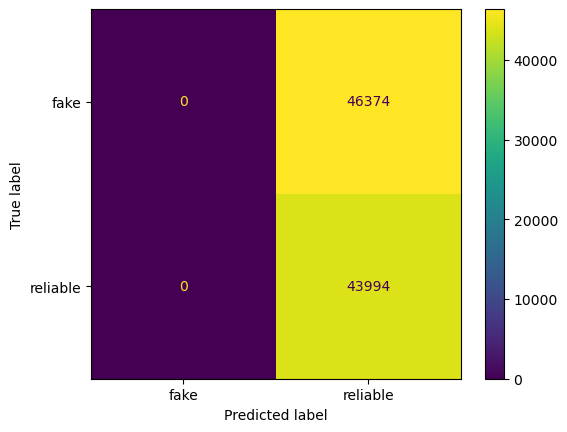

In [139]:
# simple model
test_preds_simple = logreg_nometa.predict(simple_features[test,0].reshape(-1, 1))
score_test_simple = f1_score(y[test], test_preds_simple)
print(f"Simple model test score: {score_test_simple}")

cm = ConfusionMatrixDisplay.from_estimator(logreg_nometa, simple_features[test,0].reshape(-1, 1), \
                                           y[test],display_labels=['fake','reliable'])
cm
cm.figure_.savefig('cm_simple_corpus.png')

Advanced model test score: 0.8742394176268734


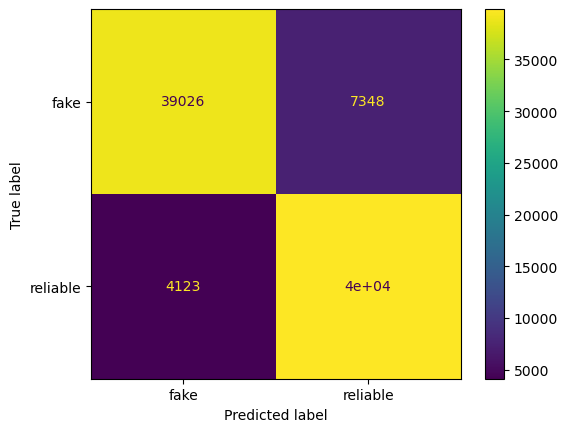

In [141]:
# advanced model - MLPclassifier
# word2vec embedding, 300 dimensions
test_preds_adv = w2v_300_MLP.predict(w2v_300_test)
score_test_adv = f1_score(y[test],test_preds_adv)
print(f"Advanced model test score: {score_test_adv}")

#test_preds_adv = w2v_300_rf.predict(w2v_300_test)
#score_test_adv = f1_score(y[test],test_preds_adv)
#print(f"random forest test score: {score_test_adv}")

cm = ConfusionMatrixDisplay.from_estimator(w2v_300_MLP, w2v_300_test, y[test],display_labels=['fake','reliable'])
cm
cm.figure_.savefig('cm_adv_corpus.png')

In [95]:
def create_liar_labels(types):
    labels_arr = np.empty(len(types))
    for i, type in enumerate(types):
        label = 0
        if type in ['mostly-true', 'half-true']:
            label = 1
        labels_arr[i] = label
    return labels_arr

liar_test = pd.read_csv("test.tsv", sep = '\t',names=['id','label','statement','subject','speaker','speaker_job','state','party','barely_true',\
                                                       'false','half-true','mostly-true','lie','context'])
liar_test_y = create_liar_labels(liar_test['label'])
print("distribution of classes", np.unique(liar_test_y, return_counts=True))

distribution of classes (array([0., 1.]), array([761, 506], dtype=int64))


# Simple and advanced model evaluation on Liar test set

Simple model test score on LIAR dataset: 0.5707839819514946


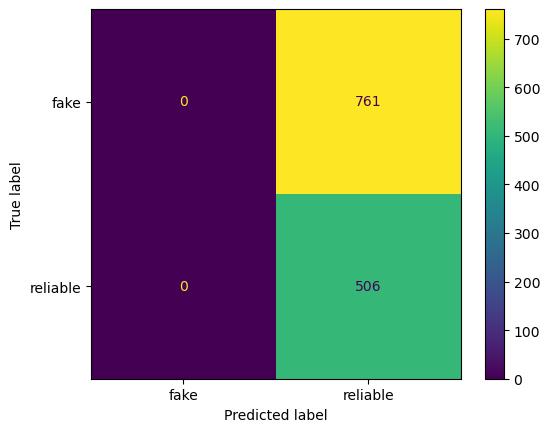

In [135]:
test_len = np.zeros(len(liar_test['statement']))
for i in range(len(liar_test['statement'])):
    content = liar_test['statement'].iloc[i]
    content_token = tokenize_content(content, stop_words, stemmer)
    test_len[i] = len(content_token)
test_preds_simple_liar = logreg_nometa.predict(test_len.reshape(-1,1))
score_test_simple_liar  = f1_score(liar_test_y, test_preds_simple_liar)
print(f"Simple model test score on LIAR dataset: {score_test_simple_liar}")

cm = confusion_matrix(liar_test_y, test_preds_simple_liar, labels=[0, 1])
cm = ConfusionMatrixDisplay.from_estimator(logreg_nometa, test_len.reshape(-1,1),\
                                           liar_test_y,display_labels=['fake','reliable'])
cm
cm.figure_.savefig('cm_simple_liar.png')

Advanced model test score on LIAR dataset: 0.05745062836624776


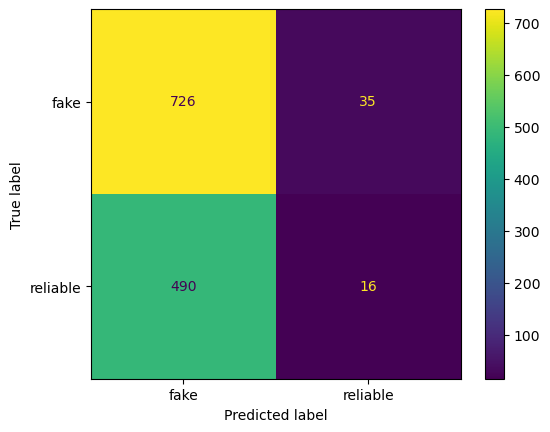

In [136]:
liar_300_test = np.array([w2v_model_300.wv.get_mean_vector(row) if row\
                          else np.zeros(300) for row in liar_test['statement']])
test_preds_adv_liar = w2v_300_MLP.predict(liar_300_test)
score_test_adv_liar = f1_score(liar_test_y, test_preds_adv_liar)
print(f"Advanced model test score on LIAR dataset: {score_test_adv_liar}")

cm = confusion_matrix(liar_test_y, test_preds_simple_liar, labels=[0, 1])
cm = ConfusionMatrixDisplay.from_estimator(w2v_300_MLP, liar_300_test ,\
                                           liar_test_y,display_labels=['fake','reliable'])
cm
cm.figure_.savefig('cm_adv_liar.png')

# Part 5

Text(-70, 10, '10')

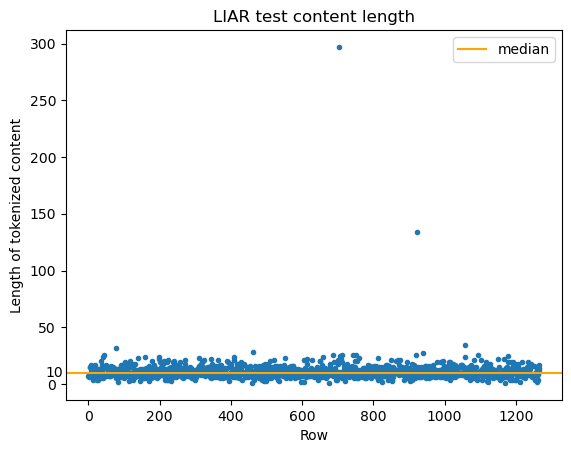

In [142]:
plt.plot(test_len, '.')
plt.axhline(y=10, color='orange', linestyle='-', label='median')
plt.ylabel('Length of tokenized content')
plt.xlabel('Row');
plt.title('LIAR test content length')
plt.legend()
plt.text(-70,10, "{:.0f}".format(10), color="black",  ha="right", va="center")


In [143]:
fake_idx = np.argsort(liar_test_y)[0:761]
real_idx = np.argsort(liar_test_y)[761::]
print("average length of content with reliable label", np.mean(test_len[real_idx]))
print("average length of content with fake label", np.mean(test_len[fake_idx]))

average length of content with reliable label 11.774703557312254
average length of content with fake label 10.724047306176084
